# Estimating network latency and capacity from asymmetric measures

We first load our dependencies and download the provided datasets if required.

In [1]:
%matplotlib inline
from os import path
from urllib.request import urlretrieve
import gzip

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
lan_url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
lan_file = 'liglab2.log.gz'

if not path.exists(lan_file):
    urlretrieve(lan_url, lan_file)
    
wan_url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz'
wan_file = 'stackoverflow.log.gz'

if not path.exists(wan_file):
    urlretrieve(wan_url, wan_file)

## First dataset: Local Area Network conditions

### Data extraction

The first dataset contains ping results. Here is an extract of the provided data.

In [3]:
with gzip.open(lan_file, 'rb') as f:
    for _ in range(5):
        print(next(f))

b'[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms\n'
b'[1421761682.277315] 1373 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n'
b'[1421761682.502054] 262 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n'
b'[1421761682.729257] 1107 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=23.3 ms\n'
b'[1421761682.934648] 1128 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=1.41 ms\n'


We create a function to parse these log lines and test it.

In [4]:
def parse_ping_line(l):
    assert len(l) > 0
    assert l[0] == '['
    
    timestamp = pd.Timestamp(float(l[1:l.index(']')]), unit='s')
    size = np.nan
    rtt = np.nan
    
    tokens = l.split(' ')
    for i, t in enumerate(tokens):
        if t == 'bytes':
            assert np.isnan(size)
            size = int(tokens[i-1])
        elif t.startswith('time='):
            rtt = float(t[len('time='):])
    
    return [timestamp, size, rtt]
    
test_line = '[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms\n'
[timestamp, size, rtt] = parse_ping_line(test_line)
assert timestamp == pd.Timestamp('2015-01-20 13:48:02.052172')
assert size == 665
assert rtt == 22.5

We can now process our full dataset and check if any data is missing.

In [5]:
rows = []
with gzip.open(lan_file, 'rb') as f:
    for l in f:
        try:
            rows.append(parse_ping_line(l.decode()))
        except (AssertionError):
            print('invalid line', l)

df = pd.DataFrame(rows, columns=['timestamp', 'size', 'rtt']).set_index('timestamp').sort_index()
print(df[df.isnull().any(axis=1)].head())

                               size  rtt
timestamp                               
2015-01-20 13:48:04.770828000    21  NaN
2015-01-20 13:48:26.146320000     9  NaN
2015-01-20 13:49:08.647974000     9  NaN
2015-01-20 13:49:48.500515999     9  NaN
2015-01-20 13:50:05.331125000    18  NaN


The value `time` is missing from some rows. We remove these measurements.

In [6]:
df = df.dropna().copy()
df.describe()

size           rtt
count  44036.000000  44036.000000
mean    1000.025729      5.136663
std      573.659666     12.221312
min       24.000000      1.000000
25%      499.000000      1.270000
50%      989.000000      1.440000
75%     1499.000000      2.310000
max     2007.000000    276.000000

### Data analysis

We plot the rtt along time axis, with different levels of zooms.

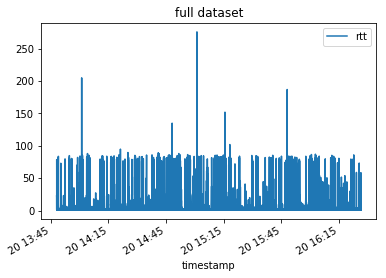

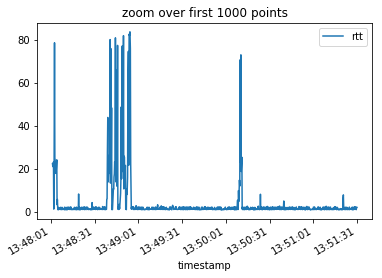

In [7]:
df.plot(y='rtt', title='full dataset')
df[:1000].plot(y='rtt', title='zoom over first 1000 points')

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


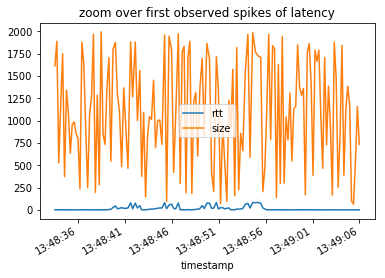

In [8]:
df[150:300].plot(y=['rtt', 'size'], title='zoom over first observed spikes of latency')

We can observe spikes of latency (rtt) in the dataset.The last plot suggests that the packet size **is not** the only parameter that affects latency.

We now study the relation between packet size and rtt.

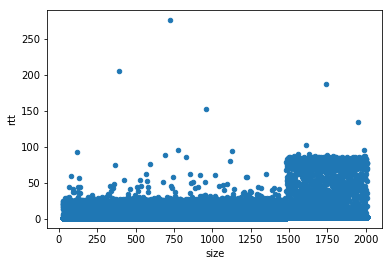

In [9]:
df.plot(x='size', y='rtt', kind='scatter')

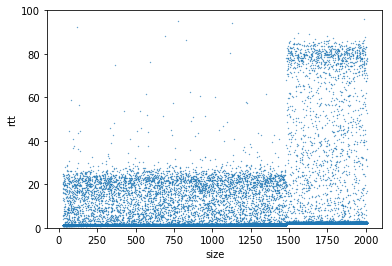

In [10]:
# Do not display outsiders on plot, reduce point size
df.plot(x='size', y='rtt', kind='scatter', ylim=(0, 100), s=.1)

We "zoom" over the discontinuity ($size \approx 1480$).

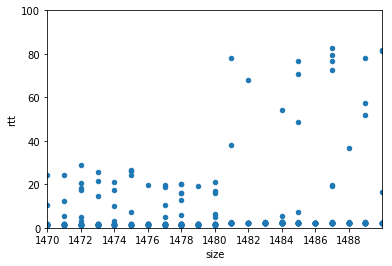

In [36]:
df.plot(x='size', y='rtt', kind='scatter', xlim=(1470,1490), ylim=(0,100), xticks=range(1470,1490, 2))

In [12]:
split = 1481
df1 = df[df['size'] < split]
df2 = df[df['size'] >= split]

We can now compute the linear regression over the two domains to find $L$ and $C$ with the following model:

$T(S) = L + \frac{S}{C}$

In [33]:
def linear_regression(df):
    X = df['size']
    X = sm.add_constant(X)
    model = sm.OLS(df['rtt'], X).fit()

    L = model.params['const']
    C = 1 / model.params['size']
    print('L = {}, C = {}'.format(L, C))
    
    S = df['size']
    plt.scatter(S, df['rtt'], label='data', s=2)
    plt.scatter(S, L+S/C, label='regression', s=2)
    plt.ylim(0, 15)
    plt.xlabel('size (bytes)')
    plt.ylabel('rtt (ms)')
    plt.legend()

L = 3.2756741993939427, C = 3064.5146168986485


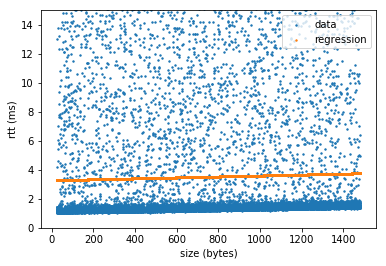

In [34]:
linear_regression(df1)

L = 5.289832573707122, C = 387.76039978488734


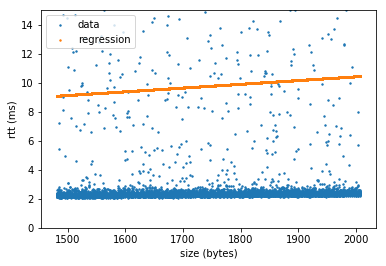

In [35]:
linear_regression(df2)